<a href="https://colab.research.google.com/github/himanshira/Deep-Learning/blob/main/Detecting_Face_Masks_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Task: Build a Transfer Learning model to detect face masks on humans

- Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, EfficientNetB0
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pathlib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import shutil
import random
import IPython.display as display
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input


In [ ]:
!unzip -q /content/Face_mask_detection.zip -d /content/Face_mask_detection

In [ ]:
#! rm -r /content/Face_mask_detection

In [ ]:
source_dir = 'Face_mask_detection/data'

# Define the new base directory where you want the split data to go
# This will create 'train', 'validation', 'test' inside 'Face_mask_detection/split_dataset'
base_split_dir = 'Face_mask_detection/split_dataset'

# Create destination directories train and test
train_dir = os.path.join(base_split_dir, 'train')
test_dir = os.path.join(base_split_dir, 'test')

# Define split ratios
train_ratio = 0.8
test_ratio = 0.2

# Ensure ratios sum to 1 (for verification)
assert train_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

# Get class names (e.g., 'with_mask', 'without_mask')
classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]
print(f"Detected classes: {classes}")

# Create class subfolders inside train, val, test directories
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    cls_path = os.path.join(source_dir, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, img))]
    random.shuffle(images) # Shuffle images for random split

    num_images = len(images)
    num_train = int(train_ratio * num_images)

    train_files = images[:num_train]
    test_files = images[num_train: ]

    print(f"Splitting class '{cls}': Train={len(train_files)}, Test={len(test_files)}")

    # Copy files to their respective new directories
    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, cls))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, cls))

print("\nData splitting complete. New structure created at:", base_split_dir)

# Verify the new structure (optional)
print("\nVerifying new structure:")
print(f"Train directory contents: {os.listdir(train_dir)}")
print(f"Test directory contents: {os.listdir(test_dir)}\n")

# Example of checking image counts in a class subfolder
print(f"Images in train/with_mask: {len(os.listdir(os.path.join(train_dir, 'with_mask')))}")
print(f"Images in train/without_mask: {len(os.listdir(os.path.join(train_dir, 'without_mask')))}")
print(f'Images in test/with_mask: {len(os.listdir(os.path.join(test_dir, "with_mask")))}')
print(f'Images in test/without_mask: {len(os.listdir(os.path.join(test_dir, "without_mask")))}')


Detected classes: ['without_mask', 'with_mask']
Splitting class 'without_mask': Train=3062, Test=766
Splitting class 'with_mask': Train=2980, Test=745

Data splitting complete. New structure created at: Face_mask_detection/split_dataset

Verifying new structure:
Train directory contents: ['without_mask', 'with_mask']
Test directory contents: ['without_mask', 'with_mask']

Images in train/with_mask: 2980
Images in train/without_mask: 3062
Images in test/with_mask: 745
Images in test/without_mask: 766


In [ ]:
# Load the Image Training and Test Datasets from the train and test folders respectively. The
#size of each image is 128 x 128 x 3
#• Load training dataset using Keras ImageDataGenerator with validation_split=0.2
#• Load test dataset using Keras ImageDataGenerator


train_data_root = '/content/Face_mask_detection/split_dataset/train'
test_data_root = '/content/Face_mask_detection/split_dataset/test'


IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
RANDOM_SEED = 42

train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load train data

train_data = train_val_datagen.flow_from_directory(
    train_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    subset = 'training',
    seed = RANDOM_SEED
)

# Load validation data

validation_data = train_val_datagen.flow_from_directory(
    train_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    subset = 'validation',
    seed = RANDOM_SEED,
    shuffle=False
)

# test data

test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_data_root,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle=False
)

print(f"Found {train_data.samples} images belonging to {train_data.num_classes} classes.")
print(f"Found {validation_data.samples} images belonging to {validation_data.num_classes} classes.")
print(f"Found {test_data.samples} images belonging to {test_data.num_classes} classes.")

print(f"Indices {train_data.class_indices}")

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.
Indices {'with_mask': 0, 'without_mask': 1}


Train root: Face_mask_detection/split_dataset/train
Test root: Face_mask_detection/split_dataset/test
Found 2980 images in train/with_mask.
Found 3062 images in train/without_mask.
Found 745 images in test/with_mask.
Found 766 images in test/without_mask.

Displaying an image from train/with_mask:


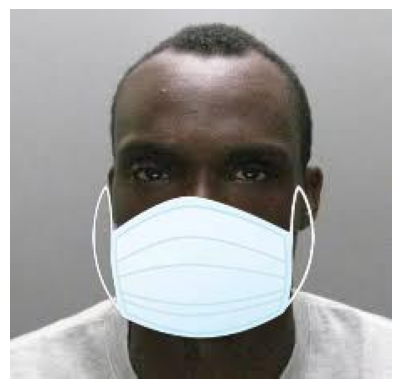


Displaying an image from train/without_mask:


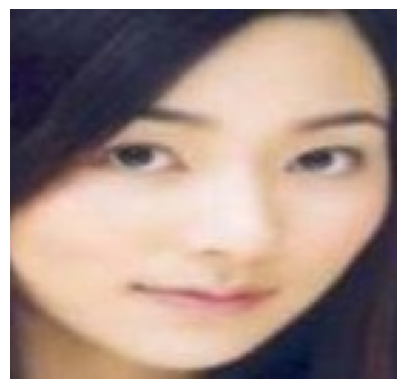


Displaying an image from test/with_mask:


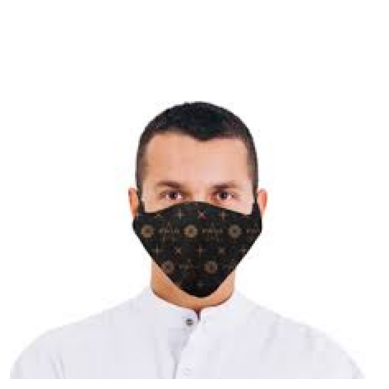


Displaying an image from test/without_mask:


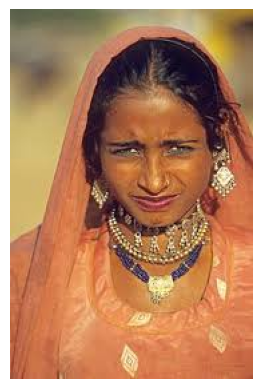

In [ ]:
import pathlib
from PIL import Image # Make sure Pillow is imported
import matplotlib.pyplot as plt # Make sure matplotlib is imported
import random # For getting random images if you want

# Assume these are correctly defined from your data loading setup:
train_data_root = 'Face_mask_detection/split_dataset/train'
test_data_root = 'Face_mask_detection/split_dataset/test'


# Define your display function
def display_images(image_path):
    img = Image.open(str(image_path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# --- CORRECTED PATH GATHERING ---
train_data_root_path = pathlib.Path(train_data_root)
test_data_root_path = pathlib.Path(test_data_root)

# Corrected globs: The patterns are now relative to the root path you've defined
with_mask_train = list(train_data_root_path.glob('with_mask/*'))
without_mask_train = list(train_data_root_path.glob('without_mask/*'))

with_mask_test = list(test_data_root_path.glob('with_mask/*'))
without_mask_test = list(test_data_root_path.glob('without_mask/*'))



# --- Debugging Prints (Highly Recommended to see if paths are found) ---
print(f"Train root: {train_data_root_path}")
print(f"Test root: {test_data_root_path}")
print(f"Found {len(with_mask_train)} images in train/with_mask.")
print(f"Found {len(without_mask_train)} images in train/without_mask.")
print(f"Found {len(with_mask_test)} images in test/with_mask.")
print(f"Found {len(without_mask_test)} images in test/without_mask.")

if len(with_mask_train) > 0:
    print("\nDisplaying an image from train/with_mask:")
    display_images(with_mask_train[0]) # Display the first image

if len(without_mask_train) > 0:
    print("\nDisplaying an image from train/without_mask:")
    # Using index 4 for demonstration, but safer to use 0 or random
    display_images(without_mask_train[min(4, len(without_mask_train) - 1)]) # Use min to prevent IndexError

if len(with_mask_test) > 0:
    print("\nDisplaying an image from test/with_mask:")
    display_images(with_mask_test[0])

if len(without_mask_test) > 0:
    print("\nDisplaying an image from test/without_mask:")
    # Using index 3 for demonstration, but safer to use 0 or random
    display_images(without_mask_test[min(3, len(without_mask_test) - 1)]) # Use min to prevent IndexError

Shape of image batch: (32, 128, 128, 3)
Shape of label batch: (32,)
Sample labels from batch: [1. 0. 0. 0. 0. 1. 1. 1. 0. 0.]


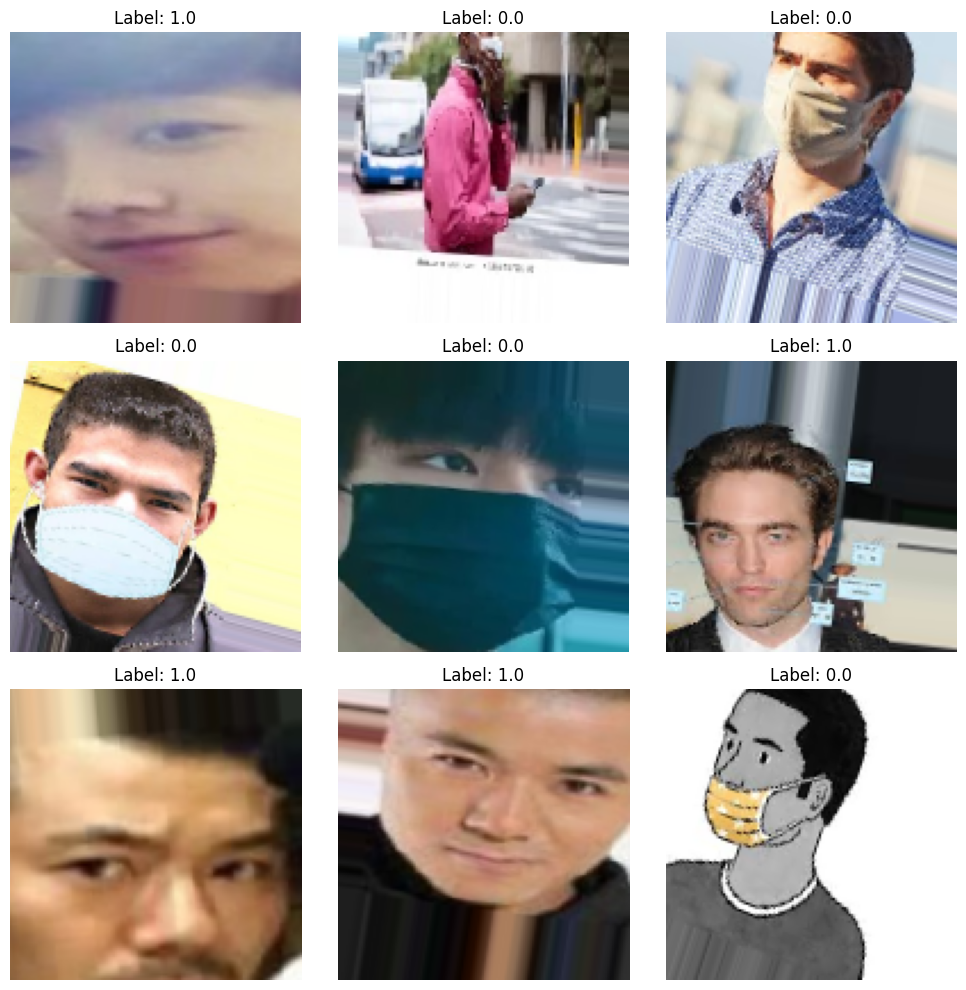

In [ ]:
import matplotlib.pyplot as plt

# Get one batch of training data
images, labels = next(train_data)

print(f"Shape of image batch: {images.shape}") # Should be (BATCH_SIZE, 128, 128, 3)
print(f"Shape of label batch: {labels.shape}") # Should be (BATCH_SIZE,)
print(f"Sample labels from batch: {labels[:10]}") # Should be 0s and 1s

# Visualize a few images from the batch
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]) # No need to un-rescale as imshow handles 0-1 well
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import Model
input_tensor = tf.keras.layers.Input(shape=(128, 128, 3))

efficientnet = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
efficientnet.trainable = False


x = efficientnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(255, activation='relu')(x)
x = Dropout(0.2)(x)
output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=efficientnet.input, outputs=output_tensor)

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,376,482 (16.69 MB)

 Trainable params: 326,911 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=1, min_lr=1e-6)

In [ ]:
epochs = 25

history1 = model1.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=validation_data,
    validation_steps=validation_data.samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = [earlystopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


105/151 ━━━━━━━━━━━━━━━━━━━━ 12s 263ms/step - accuracy: 0.4972 - loss: 0.7327

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


151/151 ━━━━━━━━━━━━━━━━━━━━ 71s 318ms/step - accuracy: 0.5009 - loss: 0.7245 - val_accuracy: 0.4966 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 2/25
  1/151 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3438 - loss: 0.7188

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.3438 - loss: 0.7188 - val_accuracy: 0.4966 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 82s 441ms/step - accuracy: 0.5067 - loss: 0.6947 - val_accuracy: 0.4966 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6875 - loss: 0.6870 - val_accuracy: 0.4966 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 5/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 82s 475ms/step - accuracy: 0.4988 - loss: 0.6933 - val_accuracy: 0.5034 - val_loss: 0.6932 - learning_rate: 0.0010
Epoch 6/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4062 - loss: 0.6997 - val_accuracy: 0.5034 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 7/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.5035 - loss: 0.6938 - val_accuracy: 0.4966 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 8/25
  1/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6875 - loss: 0.6867


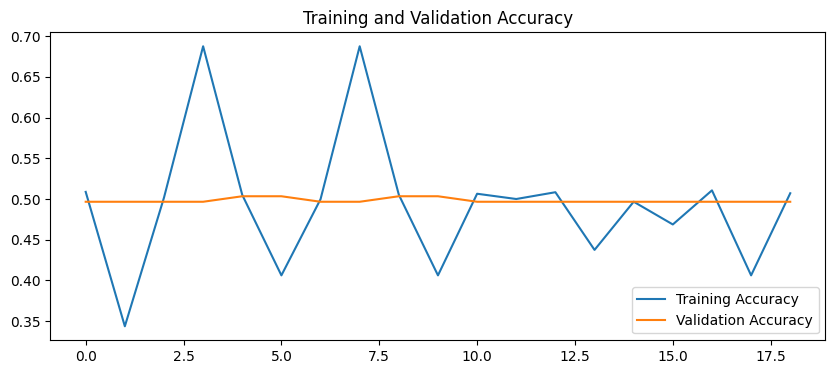

In [ ]:
# Plot training and validation accuracy and loss against epochs
epochs = 19
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

# ResNet50V2

In [ ]:
input_tensor = tf.keras.layers.Input(shape=(128, 128, 3))

resnet = ResNet50V2(include_top=False, weights='imagenet', input_tensor=input_tensor)

for layer in resnet.layers:
    layer.trainable = False

x = resnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(255, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output_tensor = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=resnet.input, outputs=output_tensor)

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 24,120,192 (92.01 MB)

 Trainable params: 555,392 (2.12 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
epochs = 25
history2 = model2.fit(
    train_data,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_data=validation_data,
    validation_steps=validation_data.samples // BATCH_SIZE,
    epochs=epochs,
    callbacks = [earlystopping, reduce_lr]
)



Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_243']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


151/151 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - accuracy: 0.9404 - loss: 0.1591 - val_accuracy: 0.9831 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9062 - loss: 0.2652 - val_accuracy: 0.9814 - val_loss: 0.0584 - learning_rate: 0.0010
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.9768 - loss: 0.0771 - val_accuracy: 0.9856 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 1.0000 - loss: 0.0281 - val_accuracy: 0.9848 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 5/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.9742 - loss: 0.0683 - val_accuracy: 0.9873 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 6/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9375 - loss: 0.1157 - val_accuracy: 0.9780 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 7/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9830 - loss: 0.05

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=h5

In [ ]:
print("Saving mask detector model...")
final_model = model2.save("ResNet50V2_model.h5")

Saving mask detector model...


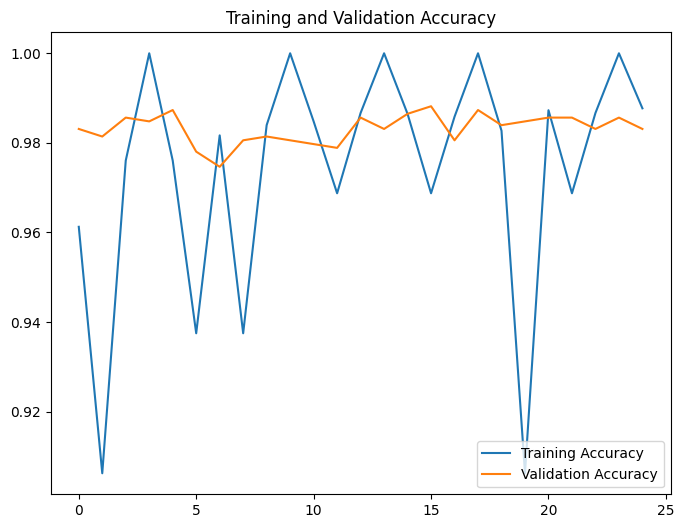

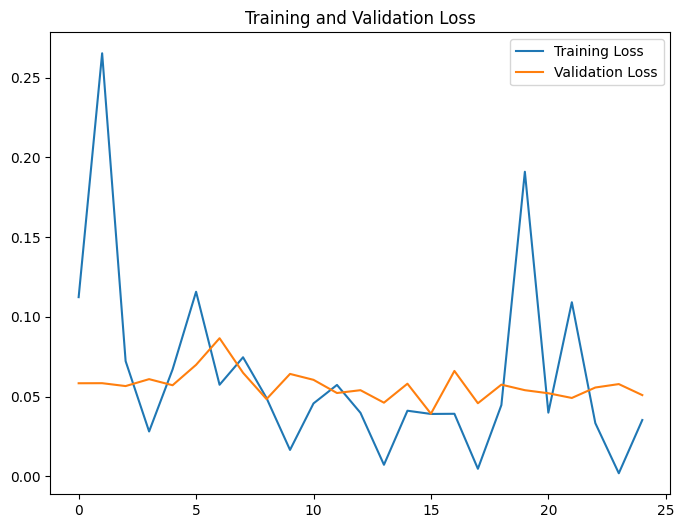

In [ ]:
# Plot with epochs

epochs_trained = len(history2.history['accuracy'])

train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs_range = range(epochs_trained)

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend(loc='upper right')
plt.show()


## Obseration

- The model using EfficientB0 is not learning
- ResNet50V2 is performing better than EfficientB0

#Testing

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("ResNet50V2_model.h5")

IMG_SIZE = (128, 128)
CONF_THRESH = 0.5

masked_dir = "with_mask"
without_mask_dir = "without_mask"

model_output_excel = "resNet50V2_model_output.xlsx"

ground_truth_labels = []
predicted_labels = []
file_names = []

for filename in os.listdir(os.path.join(test_dir, masked_dir)):
  image_path = os.path.join(test_dir, masked_dir, filename)
  image = cv2.imread(image_path)
  image = cv2.resize(image, IMG_SIZE)
  image = img_to_array(image)
  image = preprocess_input(image)

  predictions = model.predict(np.expand_dims(image, axis=0))[0]

  mask_prob = predictions[0]


  if mask_prob > CONF_THRESH:
    label = "Masked"
  else:
    label = "Unmasked"

  ground_truth_labels.append("Mask")
  predicted_labels.append(label)
  file_names.append(filename)



for filename in os.listdir(os.path.join(test_dir, without_mask_dir)):
  image_path = os.path.join(test_dir, without_mask_dir, filename)
  image = cv2.imread(image_path)
  image = cv2.resize(image, IMG_SIZE)
  image = img_to_array(image)
  image = preprocess_input(image)

  predictions = model.predict(np.expand.dims(image, axis=0))[0]

  mask_prob = predictions[0]


  if mask_prob > CONF_THRESH:
    label = "Masked"
  else:
    label = "Unmasked"
  ground_truth_labels.append("Unmasked")
  predicted_labels.append(label)
  file_names.append(filename)

with open(model_output_excel, "w") as file:
  file.write("File Name, Ground Truth Label, Predicted Label\n")
  for i in range(len(file_names)):
    file.write("{}\t{}\t{\n}".format(ground_truth_labels[i], predicted_labels[i], file_names[i]))

print("Results are written to {}".format(model_output_excel))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


IndexError: index 1 is out of bounds for axis 0 with size 1